Source: [The spelled-out intro to neural networks and backpropagation: building micrograd
](https://www.youtube.com/watch?v=VMj-3S1tku0&t=1249s&ab_channel=AndrejKarpathy)

#### What is Autograd and why is it interesting? 
Micrograd is an Autograd (short for automatic gradient) engine. It implements back propagation, an algorithm that allows to evaluate the gradient of some sort of loss function with respect to the weights of a neural network and therefore improve the accuracy of the network. 

Neural networks are just mathematical expressions: they take the input data as an input from one side and the weights of the neural network as an input, and the output are the predictions of the neural network or the loss function. 

Back propagation is significantly more general. It doesn't care about neural networks, but we happen to use this machinery to train neural networks. 

Micrograd is a scalar values autograd engine. If we want to train bigger networks we have to be using tensors, but none of the math changes, this is done purely for efficiency. Making operations on large arrays allows us to take advantage of the parallelism in the computer. It may not be pedagogically useful to be dealing with tensors from scratch. 

#### What a derivative is and what information does it bring?

In [210]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [211]:
def f(x): 
    return 3 * x**2 - 4 * x +5 

In [212]:
f(3.0)

20.0

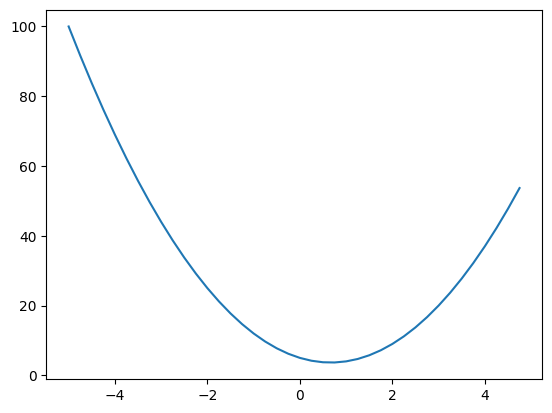

In [213]:
# values of x in a range form -5 to 5 and step 0.25
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

https://wikimedia.org/api/rest_v1/media/math/render/svg/aae79a56cdcbc44af1612a50f06169b07f02cbf3

If you slightly change the "h" (h -> 0), what influence does it have on f(a). What is the slope? Does it go up or down and by how much? 

In [214]:
h = 0.0000001
x = 3.0
f(x+h) - f(x)
# 0.01400300000000243 - by how much does it change (in the positive direction)

(f(x + h) - f(x)) / h

# when function does not respond
h = 0.0000001
x = 2 / 3
f(x + h) - f(x)
# 2.9753977059954195e-14 - almost the same, so the slope is close to "0"

2.9753977059954195e-14

In [215]:
# something more complex:
# evaluate the derivative of d with respect to a, b, and c:
h = 0.001

# 3 scalar inputs:
a = 2.0
b = -3.0
c = 10

d1 = a * b + c # d before change
# the derivative of d with respect to a is just b (which is -3) slope -> -3.0000000000001137
# a += h

# the derivative of d with respect to b is just a (which is 2) slope -> 1.9999999999997797
# b += h

# the derivative of d with respect to c is 1, because changing c moves the whole parabola up or down without changing its shape
#  slope ->  0.9999999999994458
c += h

d2 = a * b + c # d after change

print("d1", d1)
print("d2", d2)
print("slope - a.k.a the derivative", (d2 - d1) / h)

d1 4.0
d2 4.0009999999999994
slope - a.k.a the derivative 0.9999999999994458


Question
How are __repr__ and __str__ methods similar, and how do they differ from each other? 

Answer
They differ in that there is no expectation that __str__ return a valid Python expression, so a more concise, or convenient representation can be used. There is expectation that what __repr__ returns can be used to recreate the object.

They are similar in that both return a string object.
See: https://docs.python.org/3/reference/datamodel.html#object.__repr__

Question: 

If we want to be able to do: 

```python


a = Value(2.0)
b = Value(-3.0)

a + b

```
and avoid error: `TypeError: unsupported operand type(s) for +: 'Value' and 'Value'`, what method do we need to implment on Value?

Answer:
We need to be able to do: `a.__add__(b)`, so 
```
def __add__(self, other): 
    return Value(self.data + other.data)
```

Question: 

If we want to be able to do: 

```python


a = Value(2.0)
b = Value(-3.0)

a * b

```
and avoid error: `TypeError: unsupported operand type(s) for *: 'Value' and 'Value'`, what method do we need to implment on Value?

Answer:
We need to be able to do: `a.__mul__(b)`, so 
```
def __mul__(self, other): 
    return Value(self.data + other.data)
```



In [216]:
class Value: 
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0 # derivative of L with respect to this node
        self._prev = set(_children) # set is most likely for efficiency 
        self._op = _op
        self.label = label

    def __repr__(self): 
        return f"Value(data={self.data})"
    
    def __add__(self, other): 
        out = Value(self.data + other.data, (self, other), "+")
        return out
    
    def __mul__(self, other): 
        out = Value(self.data * other.data, (self, other), "*")
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
        return out
    
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")

e = a*b; e.label = "e"
d = e + c; d.label = "d"

f = Value(-2.0, label="f")
L = d * f; L.label = "L"

print(d._prev)
print(d._op)

{Value(data=10.0), Value(data=-6.0)}
+


We need some data structures that maintain these expressions: https://youtu.be/VMj-3S1tku0?t=1157

Question: 
How what __repr__ returns can be used to recreate an object? 

Answer: 
Calling eval with the __repr__ return value as argument.

In [217]:
# Create an instance
v1 = Value(-6.0)
# Get its repr string
repr_str = repr(v1)
print(repr_str)  # Output: Value(data=-6.0)

# Use eval to create a new instance from the repr string
v2 = eval(repr_str)

print(v2)  # Output: Value(data=-6.0)
print(v2.data)  # Output: -6.0

Value(data=-6.0)
Value(data=-6.0)
-6.0


In [218]:
from graphviz import Digraph

# enumerate all the nodes and edges in the graph
def trace(root): 
    nodes, edges = set(), set()
    def build(v):
        if (v) not in nodes: 
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # LR - left to right

    nodes, edges = trace(root)
    for n in nodes: 
        uid = str(id(n))
        #  for any node in the graph, create a rectangular "record" for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # if this node holds a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

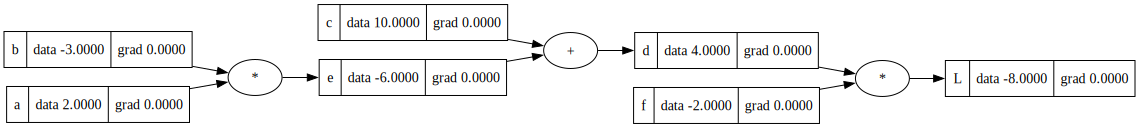

In [219]:
draw_dot(L)

L - loss function
- Build out mathematical expression using "+" and "*", with scalar values. 
- A series of values / operations that produces a single value "L" 
- We are passing value forward that produces the output value (-8.0)
  
Next, we'd like to do back-propagation: compute the derivative of L with respect to each node's value.
dL / dL, dL / df, dL / dd, dL / dc, dL / de, dl / da, dL, db

---

We're going to create a variable inside the Value class, that is going to keep the value of derivative of L with respect to that Value: https://youtu.be/VMj-3S1tku0?t=1860



Question: 
What is back propagation? 

Answer: 
??? maybe it's too early for this.

Let's start back propagation manually

In [220]:
def calculate_derivative():
    h = 0.0001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L1 = L.data

    a = Value(2.0 + h, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L2 = L.data

    print((L2 - L1) / h)

calculate_derivative()

6.000000000021544


## Let's do manual back propagation: 

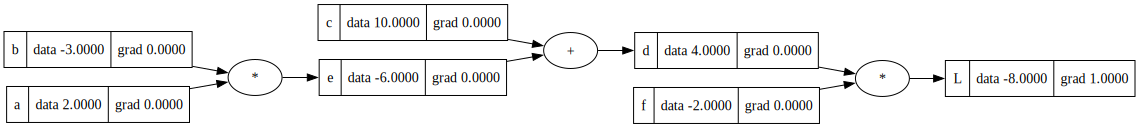

In [221]:
# What dL / dL ?
# IT's 1.0

L.grad = 1.0
draw_dot(L)

What is the derivative of L with respect to d? 
L = d * f

dL / dd = f
Proof: 

Definition of derivative: (f(x + h) - f(x)) / h

((d + h) * f - d * f) / h

df + hf - df / h

hf / h

f


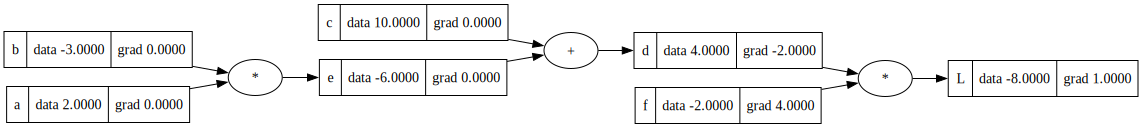

In [222]:
d.grad = -2.0
f.grad = 4.0
draw_dot(L)

To know dL / dc  we need to know dd / dc: 

d = c + e (1.0)

dd / dc = 1.0
dd / de = 1.0
The derivative of the sum expression is always 1.0


to know dL / dc, we need to refer to **chain rule:**

Question: 
What is Chain Rule? 

Answer: 
By analogy: 

If a car (z) is twice as fast as a bicycle (y) and a bicycle is four times as fast as a walking man (x), then the car travels: 
v(z) = 2y -> dz / dy = 2
v(y) = 4x -> dy / dx = 4

v(z) relative to v(x)? 
dz / dx = dz / dy * dy / dx = 2 * 4 = 8 -> multiply derivatives

Question: 
How chain rule is expressed in Leibniz's notation? 
- if we have variable z that depends on y, that in turn depends on x, then: 
dz / dx = dz / dy * dy / dx (function composition)


Question: 
How chain rule is helpful in doing back propagation? 

Answer?
???

So, plus node routes the gradient (because multiplied by 1.0):

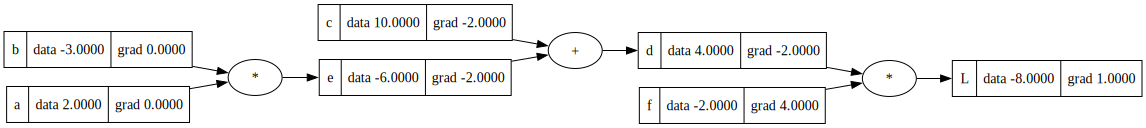

In [223]:
c.grad = -2.0
e.grad = -2.0
draw_dot(L)

dL / da ?
e = a * b

dL / de = -2.0
de / da = b -> how much e grows if a is constant; what is the slope of that function?; b
de / db = a -> how much e grows if b is constant; what is the slope of that function?; a

dL / da = dL / de * de / da
dL / da = -2.0 * -3.0 = 6
dL / db = -2.0 * 4 = -4.0

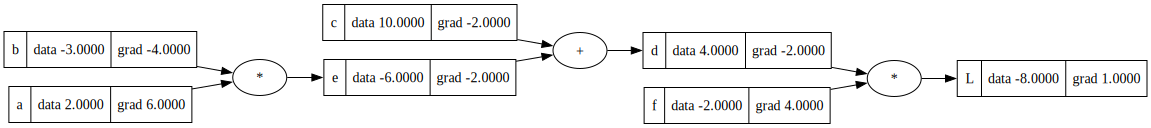

In [224]:
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

That was the manual back propagation: iterated through all the nodes and locally applied the chain rule. 

"Back propagation: recursive application of chain rule": https://youtu.be/VMj-3S1tku0?t=3070

WE're going to nudge our inputs to try to make L go up. 

-7.286496


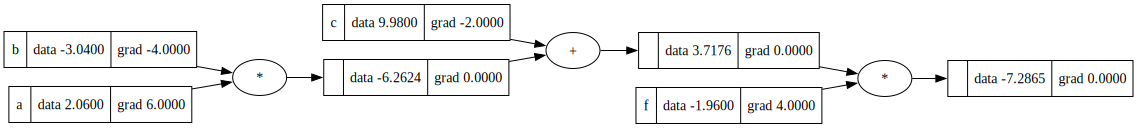

In [225]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# apply the forward pass again: 
e = a * b
d = e + c
L = d * f

print(L.data)

draw_dot(L)

#### Back-propagate through a neuron

Neuron: 
- multiple axon (x)
- synapses apply weights (w) multiplicatively
- multiple inputs (xn * wn)
- cell body: SUM(wi, xi) + b (bias) - bias (inner trigger happiness of this neuron)
- then pass it to an activation function (squashing function, e.g. tanh)

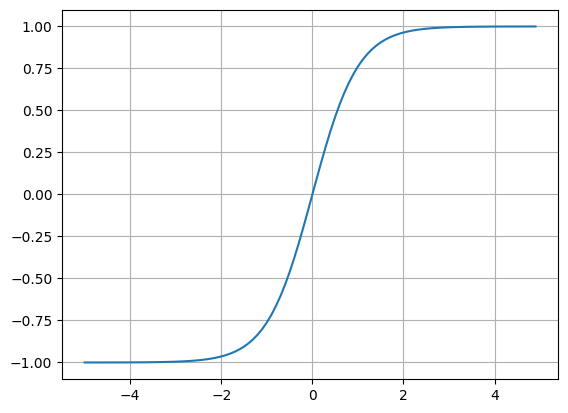

In [226]:
plt.plot(np.arange(-5, 5, 0.1), np.tanh(np.arange(-5, 5, 0.1))); plt.grid()

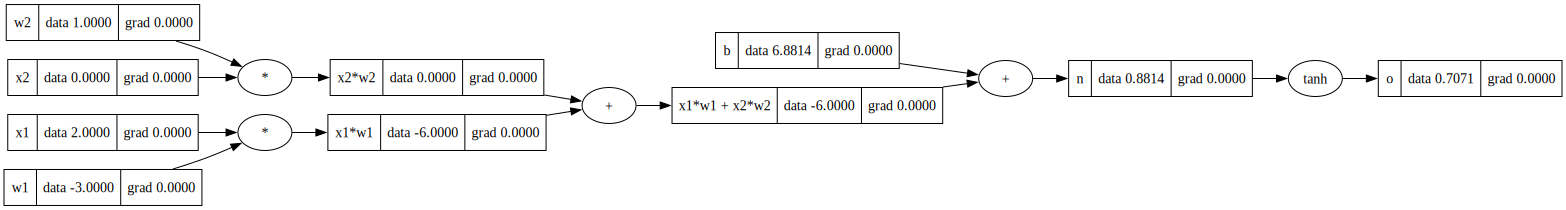

In [227]:
# inputs x2, x2 -> two dimensional neuron
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"

o = n.tanh(); o.label = "o"

draw_dot(o)

https://youtu.be/VMj-3S1tku0?t=3700

What is do / dn

do / dn = 1 - tanh(n) **2

we already have tanh(n), it's o (look up)
do / dn = 1 - o ** 2


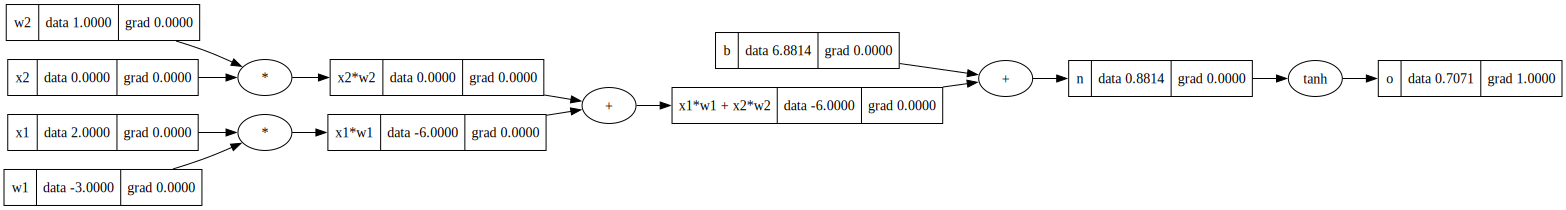

In [228]:
o.grad = 1.0
draw_dot(o)

In [229]:
1 - o.data **2

0.4999999999999999

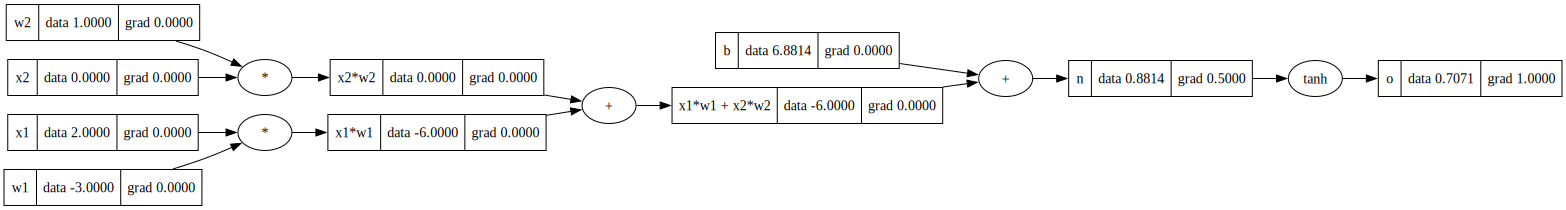

In [231]:
n.grad = 0.5

draw_dot(o)

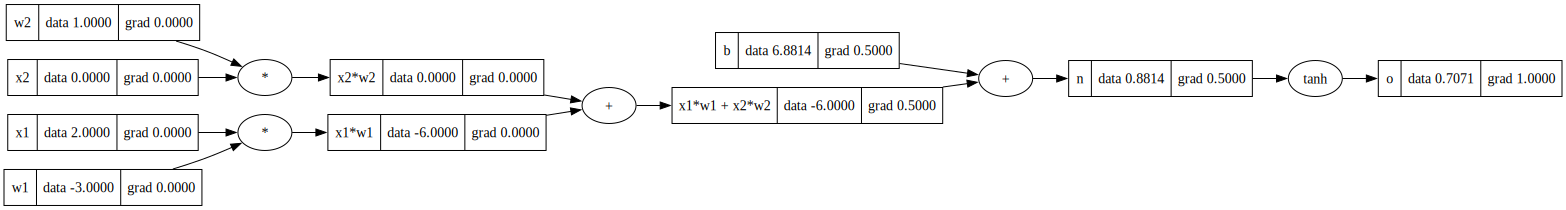

In [232]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

draw_dot(o)

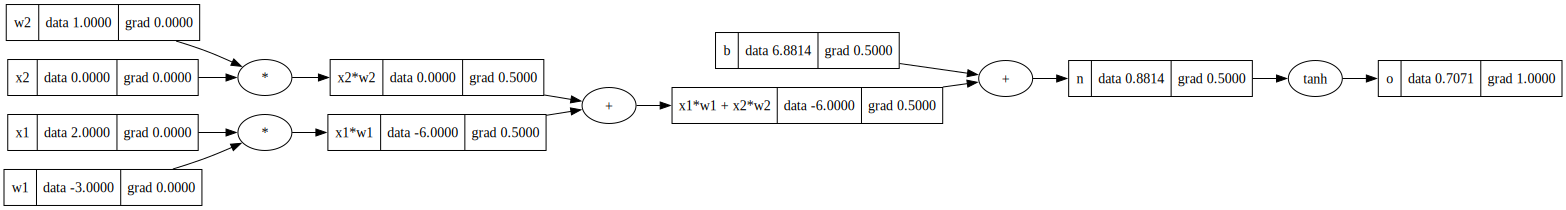

In [233]:
x1w1.grad = 0.5
x2w2.grad = 0.5

draw_dot(o)




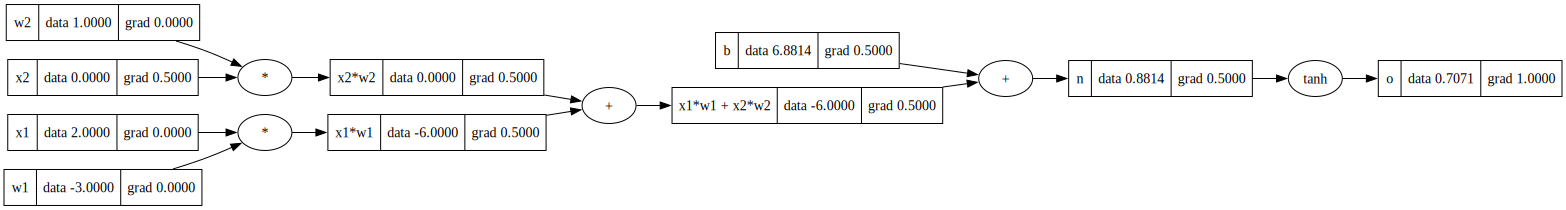

In [235]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

draw_dot(o)





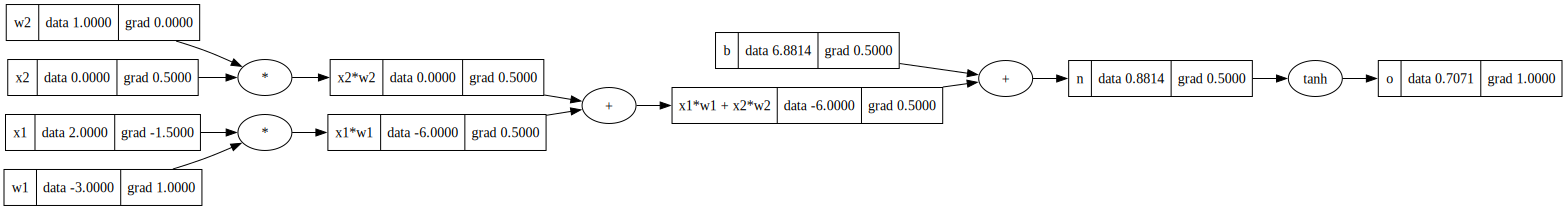

In [236]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

draw_dot(o)


